**Project Title:** Building a Recommendation System with TMDB 5000 Movie Dataset

**Authors:** Gaurav Pandey (106222), Chiraag Mishra (106073), Navnish Pandey (106141)

**Date:** 22.05.2025

### **Abstract**

*   **Data Chosen:** This project utilizes metadata from The Movie Database (TMDb) for approximately 5,000 films, encompassing details such as cast, crew, keywords, and ratings.

*   **Task:** The primary task is to build and compare two recommendation system approaches - content-based filtering and collaborative filtering, to suggest movies users would be interested in.
*   **Key findings:**
  1.   Content-based filtering handles new users well and offers high transparency, but generally provides lower serendipity.
  2.   Collaborative filtering struggles with new users and has lower explainability, but can offer greater serendipity.









###  **Introduction and Dataset Overview**
* **Source of Data:** https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata
* **Dataset Description:**
     * Key features: cast, crew, keywords, genre, ratings
     * Rows: over 4800, columns: 24

### Data Loading and Initial Exploration


In [289]:
import pandas as pd
import seaborn as sns
import ast
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
import numpy as np
import warnings
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
warnings.filterwarnings("ignore")

In [290]:
def load_data(movies_path="tmdb_5000_movies.csv", credits_path="tmdb_5000_credits.csv"):
    movies = pd.read_csv(movies_path)
    credits = pd.read_csv(credits_path)
    return movies, credits

In [291]:
movies, credits = load_data()

In [292]:
movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


In [293]:
credits.head(3)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


In [294]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [295]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [296]:
movies.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [297]:
credits.describe()

,movie_id
count,4803.000000
mean,57165.484281
std,88694.614033
min,5.000000
25%,9014.500000
50%,14629.000000
75%,58610.500000
max,459488.000000


In [298]:
movies.isnull().sum()

,0
budget,0
genres,0
homepage,3091
id,0
keywords,0
original_language,0
original_title,0
overview,3
popularity,0
production_companies,0


In [299]:
credits.isnull().sum()

,0
movie_id,0
title,0
cast,0
crew,0


### Preprocessing

* **Handling Missing Values:** Removal
* **Data Cleaning:** Removing duplicates based on movieId
* **Feature Engineering (if any):** (e.g., creating new features from existing ones, like genre extraction from movie titles, creating user/item interaction matrices) Extracting features (genre, cast, keywords) from their JSON equivalent

In [300]:
def merge_data(movies, credits):
    return movies.merge(credits, on="title")

In [301]:
def clean_data(movies):
    movies = movies[['movie_id', 'title', 'genres', 'keywords', 'cast']]
    movies.dropna(inplace=True)

    return movies

In [302]:
def parse_features(movies):
    def convert(obj):
        return [i['name'] for i in ast.literal_eval(obj)]

    def convert_cast(obj):
        return [i['name'] for i in ast.literal_eval(obj)[:3]]

    movies['genres'] = movies['genres'].apply(convert)
    movies['keywords'] = movies['keywords'].apply(convert)
    movies['cast'] = movies['cast'].apply(convert_cast)

    return movies

In [303]:
def preprocess_text(movies):
    movies['genres'] = movies['genres'].apply(lambda x: [i.replace(" ", "") for i in x])
    movies['keywords'] = movies['keywords'].apply(lambda x: [i.replace(" ", "") for i in x])
    movies['cast'] = movies['cast'].apply(lambda x: [i.replace(" ", "") for i in x])

    movies['combined'] = movies['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '') + ' ' + \
                         movies['keywords'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '') + ' ' + \
                         movies['cast'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

    return movies

### Approach 1: Content-based filtering (memory-based)

* **Approach:** Recommends items similar to a user's preferences of genres, cast, and any keywords.

* **Model Choice:** Count Vectorization with Cosine-Similarity.

In [304]:
def vectorize_tags(movies):
    cv = CountVectorizer(max_features = 5000, stop_words= 'english')
    vectors = cv.fit_transform(movies['combined']).toarray()

    return vectors, cv

In [305]:
def compute_similarity(vectors1, vectors2):
    return cosine_similarity(vectors1, vectors2)

In [306]:
def build_pipeline(movies_path="tmdb_5000_movies.csv", credits_path="tmdb_5000_credits.csv"):
    movies, credits = load_data(movies_path, credits_path)
    movies = merge_data(movies, credits)
    movies = clean_data(movies)
    movies = parse_features(movies)
    movies = preprocess_text(movies)
    vectors, cv = vectorize_tags(movies)

    return movies, vectors, cv

In [307]:
def create_user_preference_vector(cv, genres=[], actors=[], keywords=[]):
    pref_tags = []
    pref_tags += [g.replace(" ", "").lower() for g in genres]
    pref_tags += [a.replace(" ", "").lower() for a in actors]
    pref_tags += [k.replace(" ", "").lower() for k in keywords]

    pref_text = " ".join(pref_tags)
    user_vector = cv.transform([pref_text]).toarray()

    return user_vector

In [308]:
def recommend_by_user_preferences(movies, movie_vectors, cv, user_genres, user_actors, user_keywords, top_n = 5):
    user_vector = create_user_preference_vector(cv, user_genres, user_actors, user_keywords)
    similarities = compute_similarity(user_vector, movie_vectors)[0]
    top_indices = similarities.argsort()[::-1][:top_n]

    print(f"Top {top_n} movies matching your preferences (genres: {user_genres}, actors: {user_actors}, keywords: {user_keywords}):\n")
    for idx in top_indices:
        # print(f"{movies.iloc[idx]['title']} - Similarity Score: {similarities[idx]:.3f}")
        print(f"{movies.iloc[idx]['title']}")

In [309]:
movies, movie_vectors, cv = build_pipeline()

### Visualizations of top 10 genres and cast, and top 20 keywords in the dataset

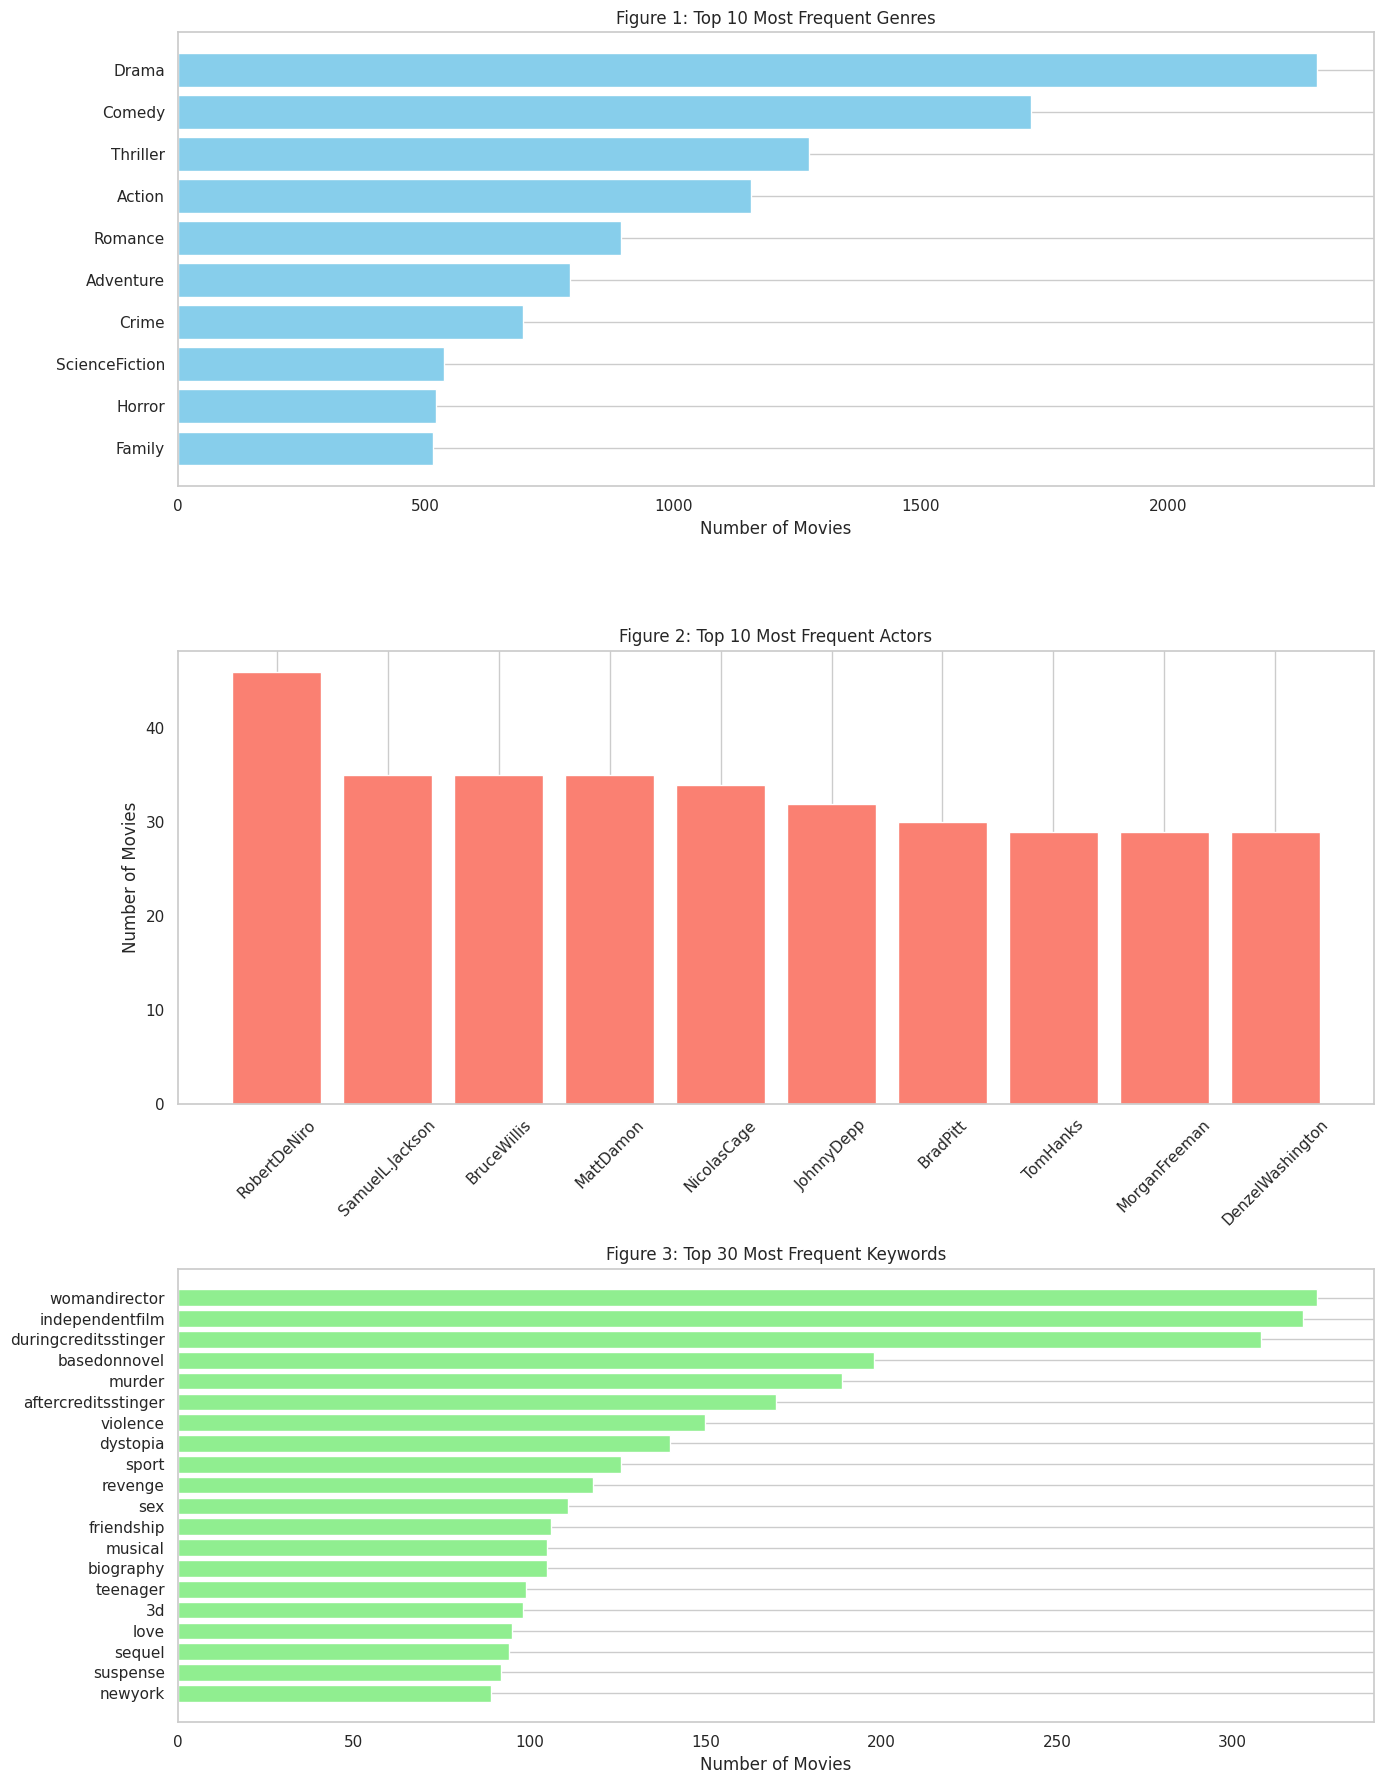

In [310]:
genre_list = [genre for sublist in movies['genres'] for genre in sublist]
genre_counts = Counter(genre_list)
top_genres = genre_counts.most_common(10)
genre_labels, genre_values = zip(*top_genres)

actor_list = [actor for sublist in movies['cast'] for actor in sublist]
actor_counts = Counter(actor_list)
top_actors = actor_counts.most_common(10)
actor_labels, actor_values = zip(*top_actors)

keyword_list = [keyword for sublist in movies['keywords'] for keyword in sublist]
keyword_counts = Counter(keyword_list)
top_keywords = keyword_counts.most_common(20)
keyword_labels, keyword_values = zip(*top_keywords)

fig, axs = plt.subplots(3, 1, figsize=(14, 18))

# Genres subplot
axs[0].barh(genre_labels, genre_values, color='skyblue')
axs[0].set_title("Figure 1: Top 10 Most Frequent Genres")
axs[0].set_xlabel("Number of Movies")
axs[0].invert_yaxis()
axs[0].grid(axis='x')

# Actors subplot
axs[1].bar(actor_labels, actor_values, color='salmon')
axs[1].set_title("Figure 2: Top 10 Most Frequent Actors")
axs[1].set_ylabel("Number of Movies")
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y')

# Keywords subplot
axs[2].barh(keyword_labels, keyword_values, color='lightgreen')
axs[2].set_title("Figure 3: Top 30 Most Frequent Keywords")
axs[2].set_xlabel("Number of Movies")
axs[2].invert_yaxis()
axs[2].grid(axis='x')

plt.tight_layout()
plt.show()

### Inference

In [311]:
if __name__ == "__main__":
    user_genres = input("Genre preference: ")
    user_actors = input("Cast preference: ")
    user_keywords = input("Keywords preference: ")

    print("\n")

    user_genres = [g.strip().replace(" ", "").lower() for g in user_genres.split(",") if g.strip()]
    user_actors = [a.strip().replace(" ", "").lower() for a in user_actors.split(",") if a.strip()]
    user_keywords = [k.strip().replace(" ", "").lower() for k in user_keywords.split(",") if k.strip()]

    recommend_by_user_preferences(movies, movie_vectors, cv, user_genres, user_actors, user_keywords, top_n=5)

Genre preference: 
Cast preference: Dwayne Johnson
Keywords preference: 


Top 5 movies matching your preferences (genres: [], actors: ['dwaynejohnson'], keywords: []):

Snitch
The Scorpion King
Faster
The Game Plan
Hercules


In [312]:
def evaluate_recommender_for_test_users(movies, movie_vectors, cv):
    test_users = [
        {
            "name": "The Rock and Hart Fan",
            "genres": ["Comedy"],
            "actors": ["Kevin Hart", "Dwayne Johnson"],
            "keywords": ["spy"]
        },
        {
            "name": "Tommie",
            "genres": ["Action", "Thriller"],
            "actors": ["Tom Cruise"],
            "keywords": ["Mission"]
        },
        {
            "name": "Bolly fanboi",
            "genres": ["romance"],
            "actors": ["Shah Rukh Khan", "Katrina Kaif"],
            "keywords": ["love"]
        }
    ]

    for user in test_users:
        print(f"\n{'='*40}")
        print(f"Evaluating recommendations for: {user['name']}")
        print(f"Preferences: Genres={user['genres']}, Actors={user['actors']}, Keywords={user['keywords']}")
        print(f"{'='*40}\n")
        recommend_by_user_preferences(movies, movie_vectors, cv,
                                      user['genres'], user['actors'], user['keywords'],
                                      top_n=5)

# Run the evaluation
evaluate_recommender_for_test_users(movies, movie_vectors, cv)



Evaluating recommendations for: The Rock and Hart Fan
Preferences: Genres=['Comedy'], Actors=['Kevin Hart', 'Dwayne Johnson'], Keywords=['spy']

Top 5 movies matching your preferences (genres: ['Comedy'], actors: ['Kevin Hart', 'Dwayne Johnson'], keywords: ['spy']):

Central Intelligence
The FP
Extreme Movie
Kevin Hart: Laugh at My Pain
About Last Night

Evaluating recommendations for: Tommie
Preferences: Genres=['Action', 'Thriller'], Actors=['Tom Cruise'], Keywords=['Mission']

Top 5 movies matching your preferences (genres: ['Action', 'Thriller'], actors: ['Tom Cruise'], keywords: ['Mission']):

Invasion U.S.A.
The Marine 4: Moving Target
Wind Walkers
Unsullied
Mission: Impossible - Ghost Protocol

Evaluating recommendations for: Bolly fanboi
Preferences: Genres=['romance'], Actors=['Shah Rukh Khan', 'Katrina Kaif'], Keywords=['love']

Top 5 movies matching your preferences (genres: ['romance'], actors: ['Shah Rukh Khan', 'Katrina Kaif'], keywords: ['love']):

Dil Jo Bhi Kahey...
M

### Approach 2: Collaborative-based filtering

This approach recommends items based on the similarity between users. We specifically implemented User-Based Collaborative Filtering.

In [313]:
ratings = pd.read_csv("ratings.csv")

In [314]:
ratings.head().style

,userId,movieId,rating
0,1,6073,1.400000
1,1,9647,3.100000
2,1,4911,4.300000
3,1,848,1.100000
4,1,18713,4.900000


In [315]:
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

In [316]:
user_similarity = cosine_similarity(user_item_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

In [317]:
#user_similarity_df

### Movie Ratings Distribution

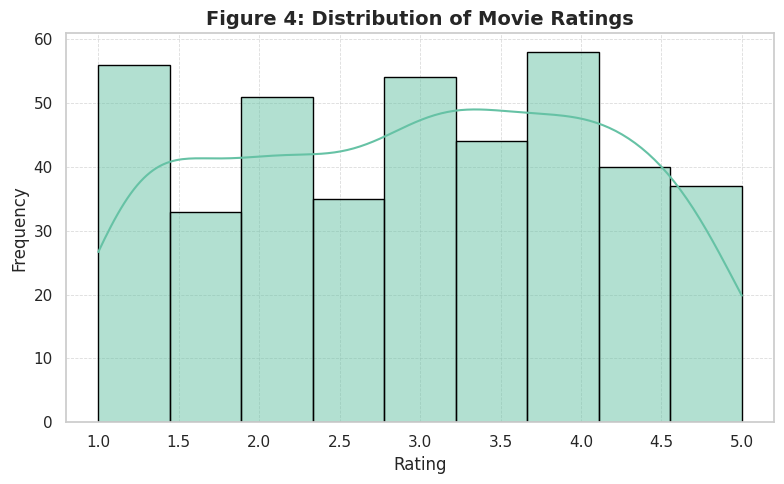

In [318]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.histplot(
    ratings['rating'],
    bins=9,
    kde=True,
    color='#66c2a5',  # soft green from Set2
    edgecolor='black'
)

plt.title("Figure 4: Distribution of Movie Ratings", fontsize=14, fontweight='bold')
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.xticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)

plt.tight_layout()
plt.show()

### User similarity heatmap


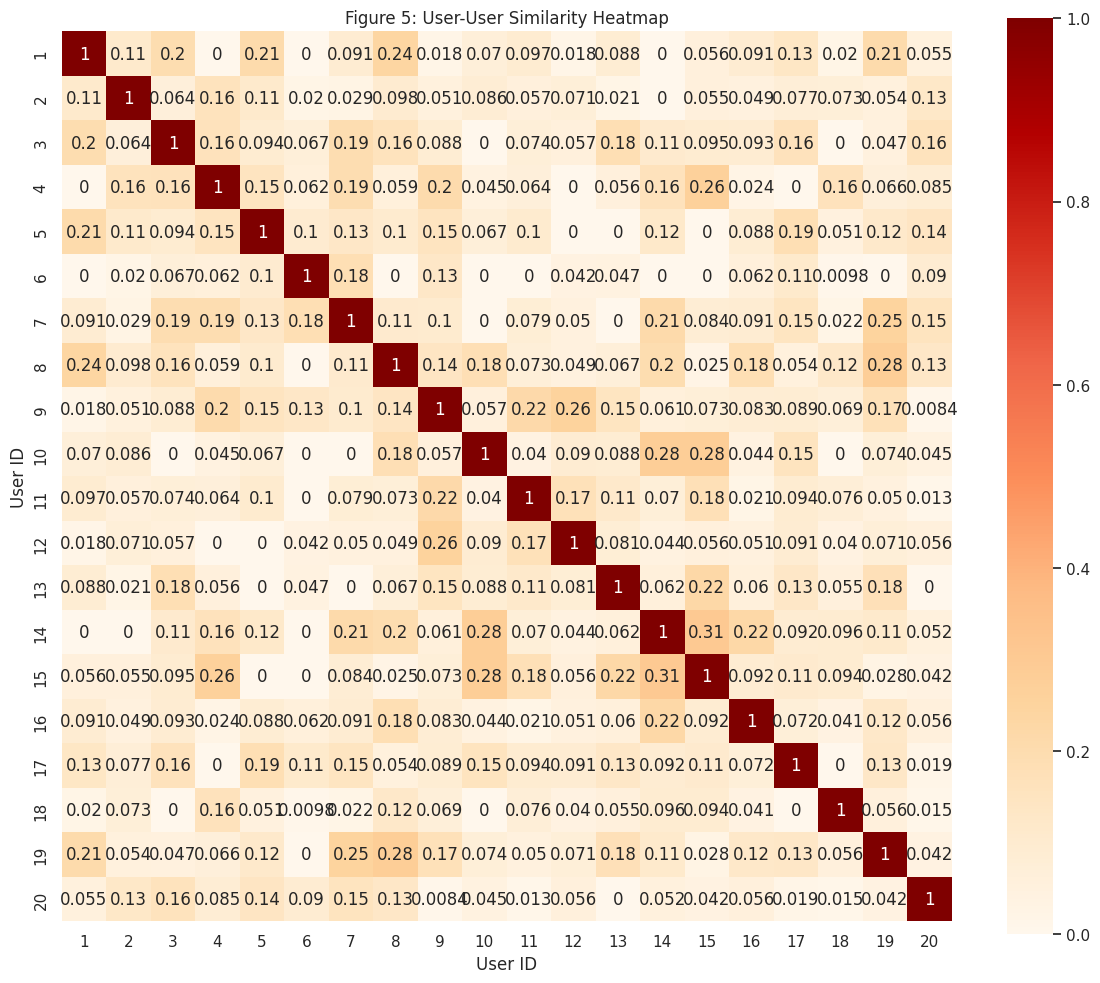

In [319]:
plt.figure(figsize=(12, 10))
sns.heatmap(user_similarity_df, cmap="OrRd", xticklabels=True, yticklabels=True, square=True, annot=True)
plt.title("Figure 5: User-User Similarity Heatmap")
plt.xlabel("User ID")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()

In [320]:
def recommend_movies(user_id, user_item_matrix, user_similarity_df, ratings_df, movies_df, top_n=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:4]
    similar_user_ids = similar_users.index.tolist()

    watched_movies = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])

    recommendations = {}
    for sim_user in similar_user_ids:
        sim_user_movies = ratings_df[ratings_df['userId'] == sim_user]
        for _, row in sim_user_movies.iterrows():
            if row['movieId'] not in watched_movies:
                if row['movieId'] not in recommendations:
                    recommendations[row['movieId']] = []
                recommendations[row['movieId']].append(row['rating'])

    recommended = sorted(recommendations.items(), key=lambda x: np.mean(x[1]), reverse=True)[:top_n]

    print(f"\nTop {top_n} recommended movies for User {user_id} based on similar users:\n")
    for movie_id, ratings_list in recommended:
        title = movies_df[movies_df['movie_id'] == movie_id]['title'].values[0]
        print(f"{title} - Estimated rating: {np.mean(ratings_list):.2f}")

    return [movie_id for movie_id, _ in recommended]

### Inference

In [321]:
for user_id in range(1, 6):
  recommend_movies(user_id=user_id, user_item_matrix=user_item_matrix, user_similarity_df=user_similarity_df, ratings_df=ratings, movies_df=movies)


Top 5 recommended movies for User 1 based on similar users:

Plastic - Estimated rating: 5.00
The Relic - Estimated rating: 4.90
My Summer of Love - Estimated rating: 4.90
Riding Giants - Estimated rating: 4.30
In Good Company - Estimated rating: 4.10

Top 5 recommended movies for User 2 based on similar users:

Daylight - Estimated rating: 4.90
Point Blank - Estimated rating: 4.90
The Merchant of Venice - Estimated rating: 4.90
The Jerky Boys - Estimated rating: 4.90
Django Unchained - Estimated rating: 4.90

Top 5 recommended movies for User 3 based on similar users:

The Jerky Boys - Estimated rating: 4.90
Rocky - Estimated rating: 4.70
Duplicity - Estimated rating: 4.70
The Work and The Story - Estimated rating: 4.70
Training Day - Estimated rating: 4.50

Top 5 recommended movies for User 4 based on similar users:

The Possession - Estimated rating: 4.70
The Jackal - Estimated rating: 4.70
American Heist - Estimated rating: 4.70
Rocky - Estimated rating: 4.70
Duplicity - Estimated

In [322]:
def evaluate_user_recommendations(user_id):
    print(f"\n{'='*60}")
    print(f"Evaluating Recommendations for User {user_id}")
    print(f"{'='*60}")

    user_history = ratings[ratings['userId'] == user_id].sort_values(by='rating', ascending=False)
    print("\nWatched Movies & Ratings:")
    for _, row in user_history.iterrows():
        title = movies[movies['movie_id'] == row['movieId']]['title'].values[0]
        print(f"{title} - Rating: {row['rating']}")

    recommended_ids = recommend_movies(user_id, user_item_matrix, user_similarity_df, ratings, movies)

    # Similar users
    print("\nTop 3 Similar Users:")
    print(user_similarity_df[user_id].sort_values(ascending=False)[1:4])

    print("\nSimilar Users' Ratings for Recommended Movies:")
    for movie_id in recommended_ids:
        title = movies[movies['movie_id'] == movie_id]['title'].values[0]
        print(f"\n{title}:")
        for sim_user in user_similarity_df[user_id].sort_values(ascending=False)[1:4].index:
            sim_rating = ratings[(ratings['userId'] == sim_user) & (ratings['movieId'] == movie_id)]['rating']
            if not sim_rating.empty:
                print(f"  User {sim_user} rated: {sim_rating.values[0]}")
            else:
                print(f"  User {sim_user} did not rate this movie")

for uid in [1, 2, 3]:
    evaluate_user_recommendations(uid)


Evaluating Recommendations for User 1

Watched Movies & Ratings:
The Jerky Boys - Rating: 4.9
Django Unchained - Rating: 4.9
Dark Blue - Rating: 4.3
Krrish - Rating: 4.2
Bella - Rating: 3.6
The Machinist - Rating: 3.4
Scrooged - Rating: 3.1
Gossip - Rating: 2.4
Newlyweds - Rating: 2.0
Captain America: Civil War - Rating: 2.0
All Hat - Rating: 1.9
Bachelorette - Rating: 1.7
Crazy in Alabama - Rating: 1.6
The Mexican - Rating: 1.4
Dragonslayer - Rating: 1.1
The Doors - Rating: 1.1
Gory Gory Hallelujah - Rating: 1.1

Top 5 recommended movies for User 1 based on similar users:

Plastic - Estimated rating: 5.00
The Relic - Estimated rating: 4.90
My Summer of Love - Estimated rating: 4.90
Riding Giants - Estimated rating: 4.30
In Good Company - Estimated rating: 4.10

Top 3 Similar Users:
userId
8     0.242061
5     0.210808
19    0.207345
Name: 1, dtype: float64

Similar Users' Ratings for Recommended Movies:

Plastic:
  User 8 rated: 5.0
  User 5 did not rate this movie
  User 19 did not 

### **Metric:** Average Rating of Recommended Items for all users

In [340]:
def average_recommendation_rating(user_id, user_similarity_df, ratings_df, top_n=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:4]
    similar_user_ids = similar_users.index.tolist()
    watched_movies = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])

    ratings_list = []
    for sim_user in similar_user_ids:
        sim_user_movies = ratings_df[ratings_df['userId'] == sim_user]
        for _, row in sim_user_movies.iterrows():
            if row['movieId'] not in watched_movies:
                ratings_list.append(row['rating'])

    avg_rating = np.mean(ratings_list) if ratings_list else 0
    #print(f"Average rating of unseen movies by similar users for User {user_id}: {avg_rating:.2f}")
    return avg_rating

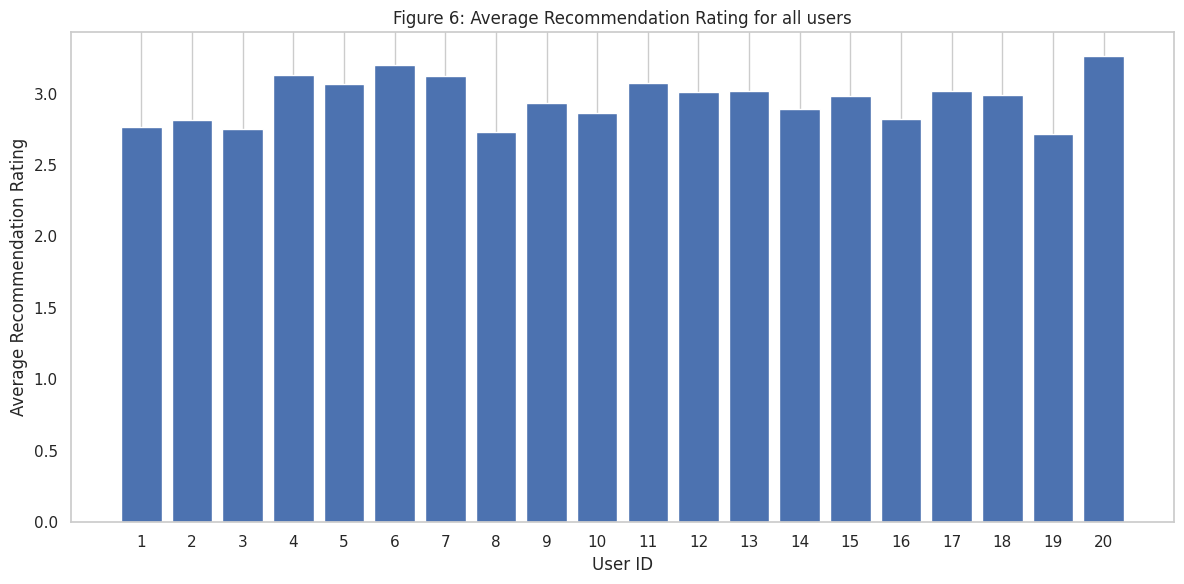

In [341]:
user_ids = range(1, 21)
avg_ratings = []

for user_id in user_ids:
    avg_rating = average_recommendation_rating(user_id=user_id,
                                               user_similarity_df=user_similarity_df,
                                               ratings_df=ratings)
    avg_ratings.append(avg_rating)

plt.figure(figsize=(12, 6))
plt.bar(user_ids, avg_ratings)
plt.xlabel("User ID")
plt.ylabel("Average Recommendation Rating")
plt.title("Figure 6: Average Recommendation Rating for all users")
plt.xticks(user_ids)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### **Challenges and Limitations**
*   Need for exact feature input in content-based filtering (misspelled/deviated inputs doesn't work)
*   Biased results because of the more frequently occuring words in the vocab built by Count Vectorizer for content-based filtering (detailed explanation below)


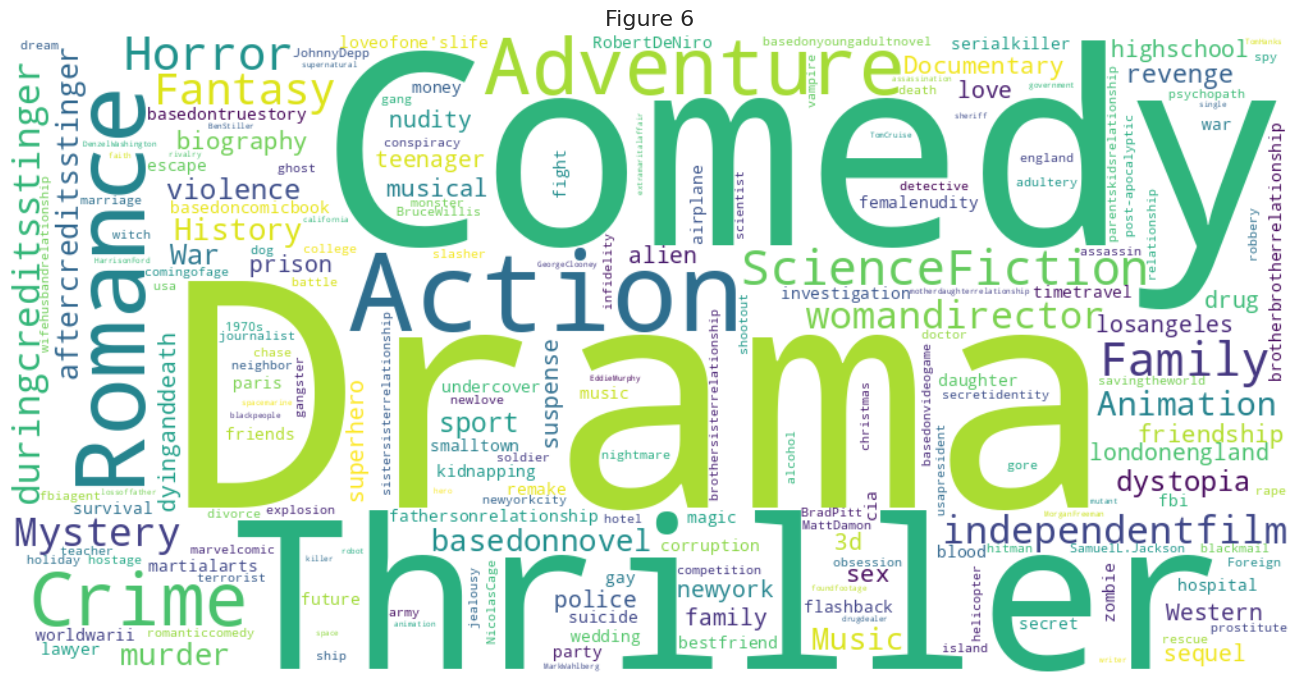

In [323]:
combined_text = " ".join(movies['combined'])
combined_wc = WordCloud(width=1000, height=500, background_color='white').generate(combined_text)

words = combined_text.split()
filtered_counts = Counter(words)
for common_word in ['movie', 'film']:
    filtered_counts.pop(common_word, None)
combined_wc = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(filtered_counts)

plt.figure(figsize=(14, 7))
plt.imshow(combined_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Figure 7", fontsize=16)
plt.tight_layout()
plt.show()

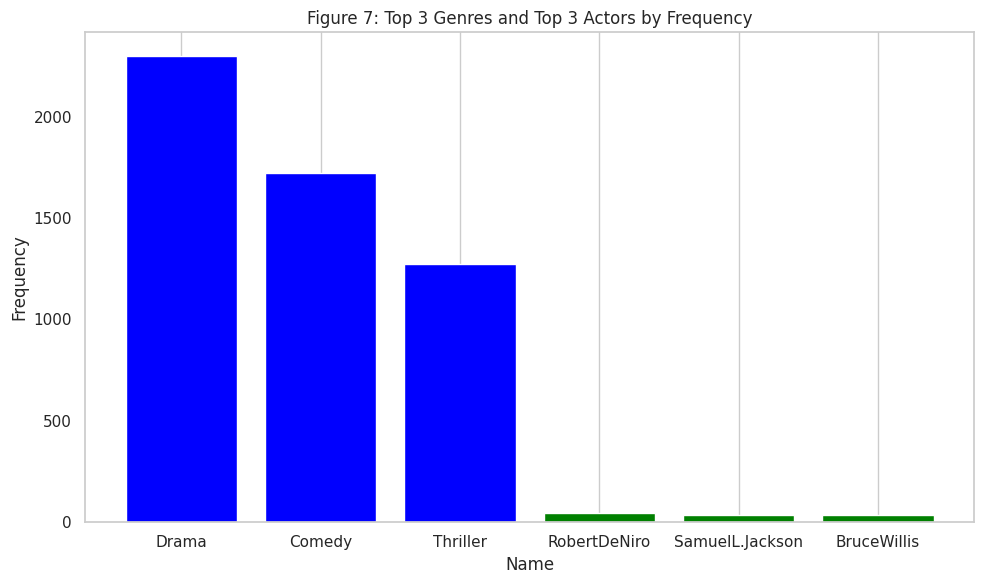

In [324]:
all_words = " ".join(movies['combined']).split()

genre_set = set(['Action', 'Adventure', 'Fantasy', 'Thriller', 'ScienceFiction', 'Drama', 'Romance', 'Comedy', 'Horror'])
actor_set = set([actor for sublist in movies['cast'] for actor in sublist])

word_counts = Counter(all_words)

genre_counts = {word: count for word, count in word_counts.items() if word in genre_set}
actor_counts = {word: count for word, count in word_counts.items() if word in actor_set}

top_genres = dict(Counter(genre_counts).most_common(3))
top_actors = dict(Counter(actor_counts).most_common(3))

labels = list(top_genres.keys()) + list(top_actors.keys())
values = list(top_genres.values()) + list(top_actors.values())
colors = ['blue'] * 3 + ['green'] * 3  # Differentiate genres and actors

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=colors)
plt.title("Figure 8: Top 3 Genres and Top 3 Actors by Frequency")
plt.xlabel("Name")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ---
# **End of Project Notebook**
# ---